In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
import os

# as 5 decimal places are there in latitude and longitude
pd.options.display.float_format = "{:0.5f}".format


#  `Task2: Build predictor for taxi drivers that predicts the next place a passenger will hail a cab`
- #### Help taxi drivers achieve less CO2 emissions and gain more profit 🙎🏼‍♂️🙎🏽‍♀️💲🌳

--- 

`Objective` is to predict `lat` and `lng` for a passenger for a taxi cab from previous trips' location and time.

## Feature Engineering

In [2]:
# normalizing lat, lng cols acc. to SF coordinates
def normalize_lat_col(lat):
    return lat - 37


def normalize_lng_col(lng):
    return lng + 122

In [3]:
def gen_passenger_loc_predict_data():
    """
    1. Loads preprocessed trips data
    2. flattens dataframe to make it look like: 
     - Training features: features from previous row such as location, trip_end_time, speed and miles
     - Labels: features from current row (trip_start_lat, trip_start_lng)
    3. Feature engineering:
     - time based features: hour of the day, day of month etc.
     - categorical time based: is_office_hours, is_weekend etc.
     - categorical macro: is_holiday, is_rain etc.
    4. Sort rows on previous trip's end time, i.e., when cab was ready to pick a new passenger
     - Assumption: At end of empty trip, there was an optimal way for a cab to get passenger.
    """

    # load trips dataframe without outliers from notebook 01.
    trips_df = pd.read_csv(
        "../data/processed_data/sf_cabs_trips_wo_outliers.csv",
        parse_dates=["trip_start_time", "trip_end_time"],
    )
    trips_df.cab_id = trips_df.cab_id.astype("category")
    trips_df.occupancy = trips_df.occupancy.astype("category")

    # flatten the dataframe by adding previous trips ending location, ending time, prvs speed and miles
    cab_ids = list(Path("../data/raw_data/cabspottingdata").glob("*.txt"))
    cab_ids = [x.stem for x in cab_ids]
    augmented_trip_df_list = []
    for cab_id in cab_ids:
        df = trips_df.loc[trips_df.cab_id == cab_id]
        prvs_trip_df = df.shift(1)[
            [
                "trip_end_lat",
                "trip_end_lng",
                "trip_end_time",
                "speed_miles_hr",
                "haver_dist_miles",
            ]
        ]
        prvs_trip_df.columns = [
            "prvs_trip_end_lat",
            "prvs_trip_end_lng",
            "prvs_trip_end_time",
            "prvs_trip_speed",
            "prvs_trip_miles",
        ]
        trip_df = pd.concat([df, prvs_trip_df], axis=1)
        trip_df = trip_df.iloc[1:, :].reset_index(drop=True)  # remove first row
        trip_df = trip_df.drop(
            columns=[
                "trip_end_lat",
                "trip_end_lng",
                "trip_end_time",
                "trip_duration",
                "speed_miles_hr",
                "haver_dist_miles",
                "trip_start_time",
            ]
        )
        # waiting time to get new passenger -> this is in future
        # trip_df['wait_time'] = trip_df['trip_start_time'] - trip_df['prvs_trip_end_time']
        augmented_trip_df_list.append(trip_df)

    # concatenate again into a combined df
    trips_df = pd.concat(augmented_trip_df_list)
    del augmented_trip_df_list

    # normalize lat,lng
    trips_df.trip_start_lat = trips_df.trip_start_lat.apply(normalize_lat_col)
    trips_df.prvs_trip_end_lat = trips_df.prvs_trip_end_lat.apply(normalize_lat_col)
    trips_df.trip_start_lng = trips_df.trip_start_lng.apply(normalize_lng_col)
    trips_df.prvs_trip_end_lng = trips_df.prvs_trip_end_lng.apply(normalize_lng_col)

    # extracting time cols
    trips_df["month"] = trips_df.prvs_trip_end_time.dt.month
    trips_df["hour"] = trips_df.prvs_trip_end_time.dt.hour
    trips_df["day"] = trips_df.prvs_trip_end_time.dt.day
    trips_df["weekday"] = trips_df.prvs_trip_end_time.apply(
        lambda x: x.isoweekday()
    )  # returns an integer for a weekday
    trips_df["is_weekday"] = np.where(trips_df.weekday.isin([1, 2, 3, 4, 5]), 1, 0)
    trips_df["is_weekend"] = np.where(trips_df.weekday.isin([6, 7]), 1, 0)
    # holiday data
    trips_df["is_holiday"] = np.where(trips_df.day == 26, 1, 0)  # memorial day in US

    # time of the day
    trips_df["is_office_time"] = np.where(
        (
            trips_df.hour.isin([7, 8, 9, 16, 17, 18])
            & (trips_df.is_weekend == 0)
            & (trips_df.is_holiday == 0)
        ),
        1,
        0,
    )
    trips_df["is_lunch_time"] = np.where(trips_df.hour.isin([12, 13]), 1, 0)
    trips_df["is_dinner_time"] = np.where(trips_df.hour.isin([19, 20, 21, 22]), 1, 0)
    trips_df["is_late_night"] = np.where(trips_df.hour.isin([23, 0, 1, 2, 3, 4, 5]), 1, 0)

    # weather data
    # https://weatherspark.com/h/m/568/2008/6/Historical-Weather-in-June-2008-in-South-San-Francisco-California-United-States#Figures-ObservedWeather
    trips_df["is_rain"] = np.where(trips_df.day.isin([24]), 1, 0)  # rainy days
    trips_df["is_fog"] = np.where(trips_df.day.isin([18, 19, 25, 3]), 1, 0)  # foggy days

    # select only rows where cab has passenger
    trips_df = trips_df.loc[trips_df.occupancy == 1].reset_index(drop=True)

    # fix dtypes
    for col in [
        "month",
        "hour",
        "day",
        "is_weekday",
        "is_weekend",
        "is_holiday",
        "is_office_time",
        "is_lunch_time",
        "is_dinner_time",
        "is_late_night",
        "is_rain",
        "is_fog",
    ]:
        trips_df[col] = trips_df[col].astype("category")

    # remove uncessary columns/data leaking columns
    del trips_df["weekday"]
    del trips_df["cab_id"]
    del trips_df["occupancy"]

    # sort rows by time
    trips_df = trips_df.sort_values(by="prvs_trip_end_time").reset_index(drop=True)
    del trips_df["prvs_trip_end_time"]

    print(trips_df.shape)
    return trips_df

## Config and MLOPs

In [66]:
config = {
    "loss": "squared_error"
}
wandb.init(config=config, project="cabspotting_pmi3")

MAE,▁▁▁██
MSE,▁▁▂██
MAE,0.00318
MSE,8e-05


# Split into train/val/test
Considering time series data, no shuffling is allowed


In [147]:
trips_df = gen_passenger_loc_predict_data()

# scale values to avoid low errors
scaler = MinMaxScaler(feature_range=(-1, 1))
cols = ['trip_start_lat', 'trip_start_lng', 'prvs_trip_end_lat', 'prvs_trip_end_lng']
trips_df[cols] = scaler.fit_transform(trips_df[cols])

lat = trips_df.pop('trip_start_lat')
lng = trips_df.pop('trip_start_lng')
X = trips_df.values

# considering low amount of data, let's do 5-fold cross-validation but for time data
tscv = TimeSeriesSplit(n_splits = 5)

(421397, 18)


## Train CV

In [148]:
def train(labels):
    scores = []
    mses = []
    maes = []
    # CROSS-VAL LOOP
    fold = 0
    for train_index, test_index in tscv.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        model = HistGradientBoostingRegressor(loss="squared_error", categorical_features=[4,5,6,7,8,9,10,11,12,13,14,15], random_state=42)
        model.fit(X_train, y_train)
        # model.get_params(deep=True)

        # Return the coefficient of determination of the prediction.
        # R^2 = How much (what %) of the total variation in Y(target) is explained by the variation in X(regression line)
        score = model.score(X_test, y_test)
        mse = mean_squared_error(y_test, model.predict(X_test))
        mae = mean_absolute_error(y_test, model.predict(X_test))

        # all regression plots
        wandb.log({"MSE": mse})
        wandb.log({"MAE": mae})
        wandb.sklearn.plot_regressor(model, X_train, X_test, y_train, y_test, model_name=f'Histogram-GBM-{fold}')

        scores.append(score)
        mses.append(mse)
        maes.append(mae)

        fold += 1
    return scores, mses, maes, model # returning last model, ideally would return best cv score model

# CV scores

In [115]:
scores_lng, mses_lng, maes_lng, model_lng = train(lng)
print(f"Rsquares: {scores_lng}")
print(f"MSE: {mses_lng}")
print(f"MAE: {maes_lng}")

Rsquares: [0.9355570212741955, 0.9291913414100152, 0.9229840083418588, 0.9370581910958883, 0.9319217171574979]
MSE: [0.00033641580767142097, 0.0003788323113535979, 0.00039003584627820393, 0.000334473532780287, 0.00035115926480111737]
MAE: [0.006322441495110925, 0.006131959274852958, 0.006257634404436905, 0.00648504920825769, 0.006485056319774407]


In [116]:
scores_lat, mses_lat, maes_lat, model_lat = train(lat)
print(f"Rsquares: {scores_lat}")
print(f"MSE: {mses_lat}")
print(f"MAE: {maes_lat}")

Rsquares: [0.9640769899959427, 0.9771123730338582, 0.9697130833397233, 0.9727575341498813, 0.9727564685561335]
MSE: [0.0004046835475331588, 0.00030499251817227123, 0.0003225028882900651, 0.00041620537771852633, 0.00036867859083306254]
MAE: [0.004691223941069543, 0.004540948642979723, 0.0044487161334886205, 0.005138288956334727, 0.004977112363090267]


In [117]:
# If the sum of Squared Error of the regression line is small => R² will be close to 1 
print(f"Passenger LONGITUDE prediction avg. MSE 5 split CV: {np.array(mses_lng).mean()}")
print(f"Passenger LATITUDE prediction avg. MSE 5 split CV: {np.array(mses_lat).mean()}")
print(f"Passenger LONGITUDE prediction avg. MAE 5 split CV: {np.array(maes_lng).mean()}")
print(f"Passenger LATITUDE prediction avg. MAE 5 split CV: {np.array(maes_lat).mean()}")
print(f"Passenger LONGITUDE prediction avg. Rsquared score 5 split CV: {np.array(scores_lng).mean()}")
print(f"Passenger LATITUDE prediction avg. Rsquared score 5 split CV: {np.array(scores_lat).mean()}")

Passenger LONGITUDE prediction avg. MSE 5 split CV: 0.00035818335257692543
Passenger LATITUDE prediction avg. MSE 5 split CV: 0.0003634125845094168
Passenger LONGITUDE prediction avg. MAE 5 split CV: 0.006336428140486576
Passenger LATITUDE prediction avg. MAE 5 split CV: 0.004759258007392577
Passenger LONGITUDE prediction avg. Rsquared score 5 split CV: 0.9313424558558913
Passenger LATITUDE prediction avg. Rsquared score 5 split CV: 0.9712832898151078


# Prediction
Prediction is demonstrated below

--- 

## Policy Layer

- In real-world, I would code a policy layer on top of recommendation/prediction to point driver to the nearest
checkpoint that is known on maps (for example, a hospital, market, parking lot etc.)
- Other thing that might be useful would be taking into account `empty-cab density` in a area! If there are lots
  of empty cabs in a nearby location, don't refer a nearby location to the driver.

In [140]:
example = np.array([[37.773972, -122.431297, 20,10, 5, 10, 17, 0,  1,  0, 0,  0,  0,  0,  0, 0],])
lat_pred = model_lat.predict(example)
lng_pred = model_lng.predict(example)
lat_pred, lng_pred

(array([0.62349113]), array([-0.77378317]))

In [141]:
lat =scaler.inverse_transform(np.array([[0.62349113,0,0,0]]))
lng = scaler.inverse_transform(np.array([[0,-0.77378317,0,0]]))
lat[0][0] + 37, lng[0][1] - 122

(37.8479457802385, -122.49906000662939)

In [144]:
import folium

# Choosing the map type
m = folium.Map(
    location=[37.77, -122.42],
    zoom_start=11,
    min_zoom=10,
    width=500,
    height=500,
)

folium.Marker(
      location=[37.773972, -122.431297],
      popup='input',
   ).add_to(m)

folium.Marker(
      location=[37.8479457802385, -122.49906000662939],
      popup='prediction',
   ).add_to(m)

m

## MLOps demonstration

In [ ]:
scores_lng, mses_lng, maes_lng, model = train(lng)

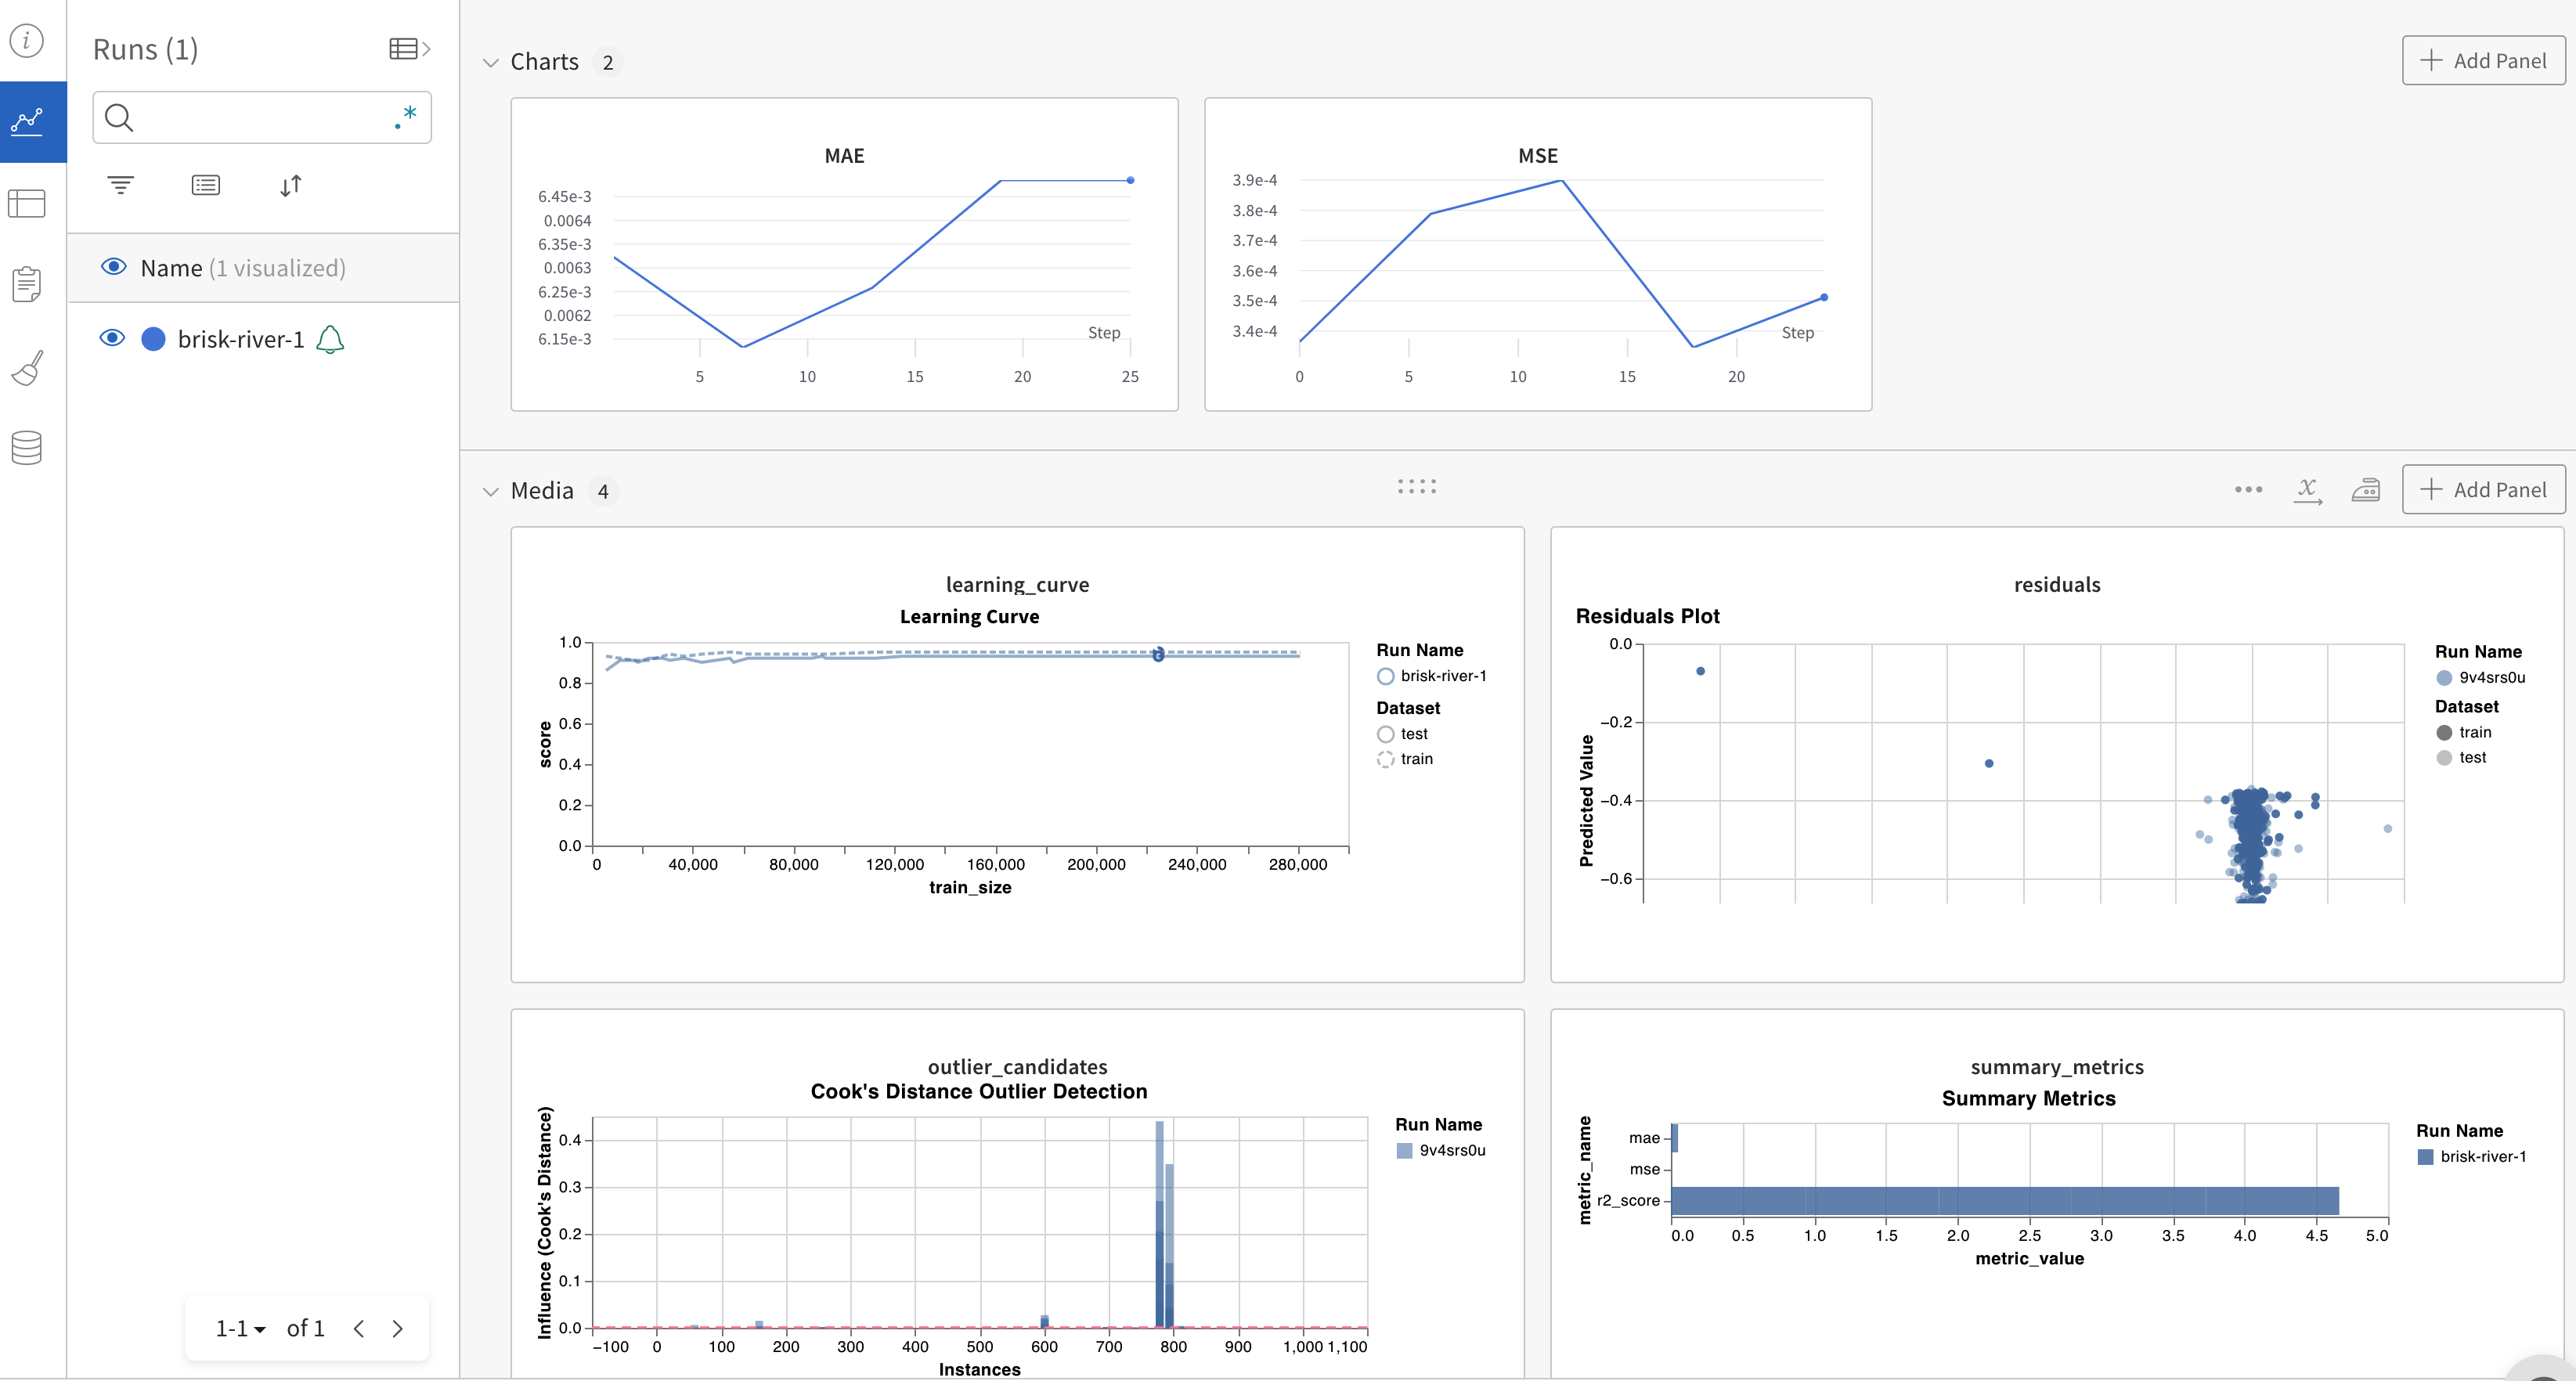

In [152]:
Image('../images/mlops.png')

# other macro-features for today's world

- temperature, humidity (is_cold/is_hot/is_humid)
- is covid wave/quarantine
- is event or sale
- is holiday season (esp. for NL)
- % of people working-from-home